
# Implementation of VIX-Yield Curve Cycles Model for Predicting Recession

## Introduction
This notebook implements the VIX-Yield Curve Cycles Model proposed by [Anne Lundgaard Hansen](https://deliverypdf.ssrn.com/delivery.php?ID=670117070070068016070122028120086120031047031042055074081066122024121075069003090124049107118055103025009101117068106120080114028035061021010087094099071084093123112003008009003099096095087080102027120018099009074011123098022089076010115083117113021103&EXT=pdf&INDEX=TRUE) and attempts to evaluate the probit model proposed against various other machine learning models using the same VIX-Yield Curve Cycle Indicators to find the ideal methods for predicting recession. 

## Construct VIX-Yield Curve Cycle Indicators

### Collect Data
First, I construct the VIX-Yield Curve Cycles Indexes as proposed in the article, which has shown to perform significantly better in predicting recession than the yield curve spread. I use VIX ([CBOE Volatility Index](https://fred.stlouisfed.org/series/VIXCLS)) and yield curve spread data ([10-Year Treasury Constant Maturity Minus 3-Month Treasury Constant Maturity](https://fred.stlouisfed.org/series/T10Y3M)) collected from FRED for the period 1990-01-02 to 2023-08-15.


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np

# import data and merge
vix = pd.read_csv('./VIXCLS.csv')
yieldCurve = pd.read_csv('./T10Y3M.csv')

vixYieldCurve = vix.merge(yieldCurve, on='DATE')
vixYieldCurve['DATE'] = pd.to_datetime(vixYieldCurve['DATE'])
vixYieldCurve.set_index('DATE', inplace=True)
vixYieldCurve = vixYieldCurve.replace('.',np.nan).dropna()

vixYieldCurve['VIXCLS'] = vixYieldCurve['VIXCLS'].astype('float64') 
vixYieldCurve['T10Y3M'] = vixYieldCurve['T10Y3M'].astype('float64') 

# find 2 year moving averages
vixYieldCurve['SMOOTHED_VIXCLS'] = vixYieldCurve['VIXCLS'].rolling(window=730,min_periods=1).mean()
vixYieldCurve['SMOOTHED_T10Y3M'] = vixYieldCurve['T10Y3M'].rolling(window=730,min_periods=1).mean()

### VIX-Yield Curve Relational Data
I plot the smoothed Yield Curve data against the smoothed VIX data to examine their relationships per business cycle from 1990-2023.

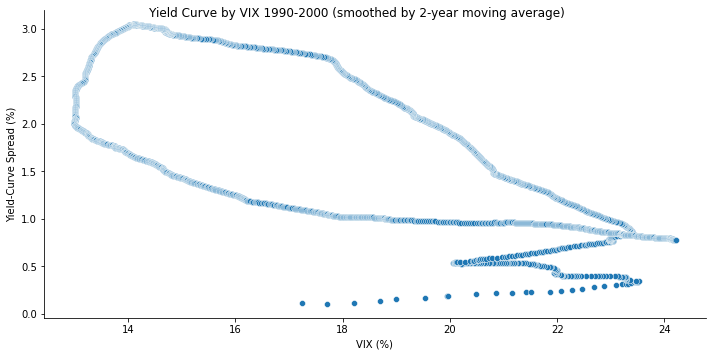

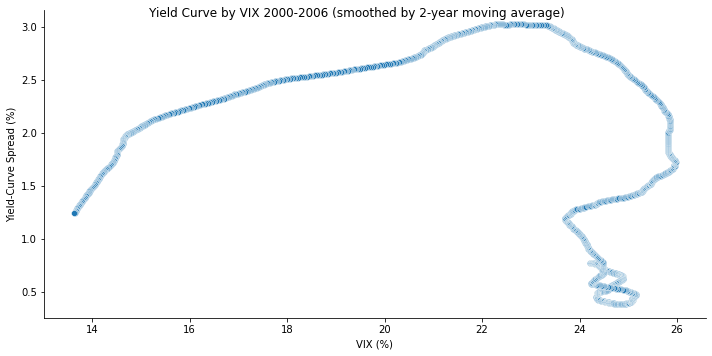

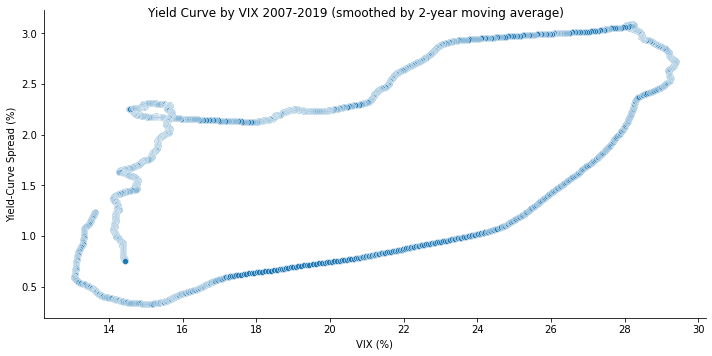

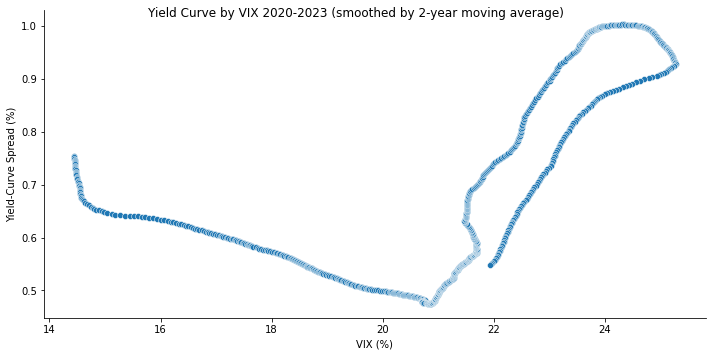

In [4]:
# plot the data
g1 = sns.relplot(data=vixYieldCurve['1990-01-02':'2000-01-02'], x='SMOOTHED_VIXCLS', y='SMOOTHED_T10Y3M', aspect=2)
g1.set(xlabel='VIX (%)', ylabel="Yield-Curve Spread (%)")
g1.figure.suptitle(
    "Yield Curve by VIX 1990-2000 (smoothed by 2-year moving average)",
    fontsize=12,
    fontdict={"weight": "bold"}
);

g2 = sns.relplot(data=vixYieldCurve['2000-01-02':'2007-01-02'], x='SMOOTHED_VIXCLS', y='SMOOTHED_T10Y3M', aspect=2)
g2.set(xlabel='VIX (%)', ylabel="Yield-Curve Spread (%)")
g2.figure.suptitle(
    "Yield Curve by VIX 2000-2006 (smoothed by 2-year moving average)",
    fontsize=12,
    fontdict={"weight": "bold"}
);

g3 = sns.relplot(data=vixYieldCurve['2007-01-02':'2020-01-02'], x='SMOOTHED_VIXCLS', y='SMOOTHED_T10Y3M', aspect=2)
g3.set(xlabel='VIX (%)', ylabel="Yield-Curve Spread (%)")
g3.figure.suptitle(
    "Yield Curve by VIX 2007-2019 (smoothed by 2-year moving average)",
    fontsize=12,
    fontdict={"weight": "bold"}
);

g4 = sns.relplot(data=vixYieldCurve['2020-01-02':'2023-08-15'], x='SMOOTHED_VIXCLS', y='SMOOTHED_T10Y3M', aspect=2)
g4.set(xlabel='VIX (%)', ylabel="Yield-Curve Spread (%)")
g4.figure.suptitle(
    "Yield Curve by VIX 2020-2023 (smoothed by 2-year moving average)",
    fontsize=12,
    fontdict={"weight": "bold"}
);

I found that the figures are similar to the ones in Lundgren's paper:
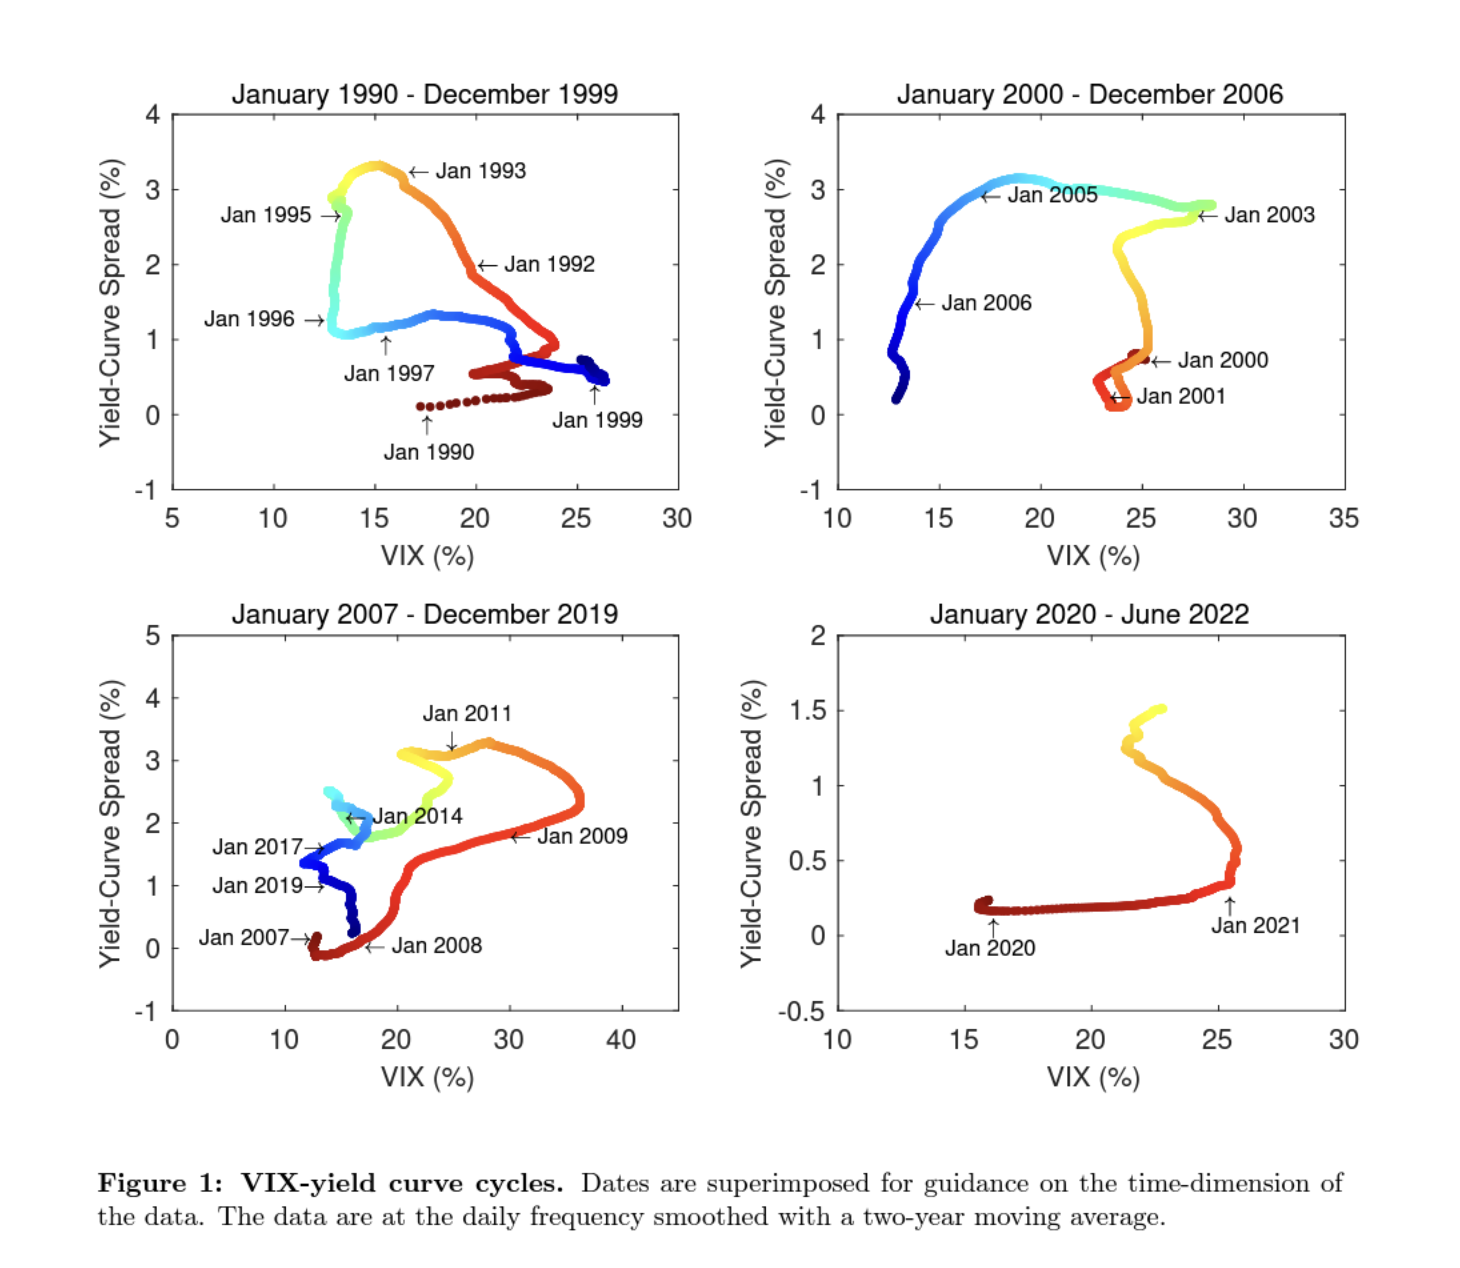


Economic recession happens when yield curve spreads are low and the level of the VIX index is high whereas economic recovery is associated with lower values in the yield curve spreads and a high value in the VIX index. From the figures above, we can observe periods of recession in the lower right corner, and recovery in the upper left corener. Thus, a business cycle follows a counter-clockwise movement through the VIX-Yield Curve Cycle.

### Create Indicators
Then, I create the three indicators proposed in Lundgren's research. 

#### 1. Non-Standardized VIX-Yield Curve Cycle Indicator
I obtain the Non-Standardized VIX-Yield Curve Cycle Indicator with Yield Curve Spread 2-Year Moving Average / VIX 2-Year Moving Average.


In [10]:
vixYieldCurve['NONSTANDARDIZED_VIX_T10Y3M_INDEX'] = vixYieldCurve['SMOOTHED_T10Y3M'] / vixYieldCurve['SMOOTHED_VIXCLS']
vixYieldCurve['NONSTANDARDIZED_VIX_T10Y3M_INDEX']

DATE
1990-01-10    0.009165
1990-01-11    0.009517
1990-01-12    0.010198
1990-01-16    0.010502
1990-01-17    0.010357
                ...   
2023-08-09    0.025351
2023-08-10    0.025246
2023-08-11    0.025151
2023-08-14    0.025051
2023-08-15    0.024952
Name: NONSTANDARDIZED_VIX_T10Y3M_INDEX, Length: 8391, dtype: float64

#### 2. Standardized VIX-Yield Curve Cycle Indicator
I nomalize the two moving averages with the 8-year moving averages and standard error and obtain the Standardized VIX-Yield Curve Cycle Indicator as the z-score. Then, I remove any unusual data points where z > 3 or or z < -3.

In [9]:
from scipy import stats

def zscore(x, window):
    r = x.rolling(window=window, min_periods=1)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z


vixYieldCurve['STANDARDIZED_VIXCLS'] = zscore(vixYieldCurve['SMOOTHED_VIXCLS'], 2008)
vixYieldCurve['STANDARDIZED_T10Y3M'] = zscore(vixYieldCurve['SMOOTHED_T10Y3M'], 2008)
vixYieldCurve.replace([np.inf, -np.inf], np.nan, inplace=True)
vixYieldCurve.dropna(subset=["STANDARDIZED_VIXCLS", "STANDARDIZED_T10Y3M"], how="all", inplace=True)


vixYieldCurve['STANDARDIZED_VIXCLS'] = np.where(vixYieldCurve['STANDARDIZED_VIXCLS']> 3, 3, vixYieldCurve['STANDARDIZED_VIXCLS'])
vixYieldCurve['STANDARDIZED_VIXCLS'] = np.where(vixYieldCurve['STANDARDIZED_VIXCLS']< -3, -3, vixYieldCurve['STANDARDIZED_VIXCLS'])

vixYieldCurve['STANDARDIZED_T10Y3M'] = np.where(vixYieldCurve['STANDARDIZED_T10Y3M']> 3, 3, vixYieldCurve['STANDARDIZED_T10Y3M'])
vixYieldCurve['STANDARDIZED_T10Y3M'] = np.where(vixYieldCurve['STANDARDIZED_T10Y3M']< -3, -3, vixYieldCurve['STANDARDIZED_T10Y3M'])

vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX'] = vixYieldCurve['STANDARDIZED_T10Y3M'] / vixYieldCurve['STANDARDIZED_VIXCLS']
vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX'] = np.where(vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX']> 3, 3, vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX'])
vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX'] = np.where(vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX']< -3, -3, vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX'])
vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX']

DATE
1990-01-10    1.173111
1990-01-11    1.618445
1990-01-12    1.182623
1990-01-16    0.960316
1990-01-17    0.731951
                ...   
2023-08-09   -0.943013
2023-08-10   -0.951538
2023-08-11   -0.960458
2023-08-14   -0.968696
2023-08-15   -0.976686
Name: STANDARDIZED_VIX_T10Y3M_INDEX, Length: 8391, dtype: float64

#### 3. Elliptical VIX-Yield Curve Cycle Indicator
Since the business cycle follows a counter-clockwise rotation, Lundgren suggests using elliptical analysis by fitting an ellipse over the VIX-Yield Curve to produce an indicator as the distance from the ellipse's center. This way, the indicator (distance from the ellipse's center) represents the economy's location on the business cycle.  Below, I create the indicator with the same approach:

center =  (20.564652907276546, 1.7938588261719295)
angle of rotation =  0.025964298200773624
axes =  (6.7085837805891, 1.210532554926187)


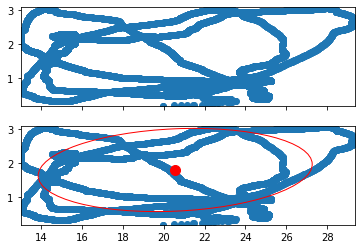

DATE
1990-01-10   -0.066980
1990-01-11   -0.007883
1990-01-12   -0.045229
1990-01-16   -0.015095
1990-01-17    0.018602
                ...   
2023-08-09    0.149555
2023-08-10    0.149687
2023-08-11    0.149799
2023-08-14    0.149922
2023-08-15    0.150041
Name: ELLIPSE_VIX_T10Y3M_INDEX, Length: 8391, dtype: float64

In [11]:
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt


x = vixYieldCurve['SMOOTHED_VIXCLS']
y = vixYieldCurve['SMOOTHED_T10Y3M']
xy_points = np.array(list(zip(x, y)))
ell = EllipseModel()
ell.estimate(xy_points)

xc, yc, a, b, theta = ell.params

print("center = ",  (xc, yc))
print("angle of rotation = ",  theta)
print("axes = ", (a,b))

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
axs[0].scatter(x,y)

axs[1].scatter(x, y)
axs[1].scatter(xc, yc, color='red', s=100)
axs[1].set_xlim(x.min(), x.max())
axs[1].set_ylim(y.min(), y.max())

ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

axs[1].add_patch(ell_patch)
plt.show()


vixYieldCurve['DIST_VIXCLS'] = vixYieldCurve['STANDARDIZED_VIXCLS'] - xc
vixYieldCurve['DIST_T10Y3M'] = vixYieldCurve['STANDARDIZED_T10Y3M'] - yc
vixYieldCurve['ELLIPSE_VIX_T10Y3M_INDEX'] = vixYieldCurve['DIST_T10Y3M']/ vixYieldCurve['DIST_VIXCLS']
vixYieldCurve['ELLIPSE_VIX_T10Y3M_INDEX']

### Plot Indicators
I plot the three indicators by date as follows:

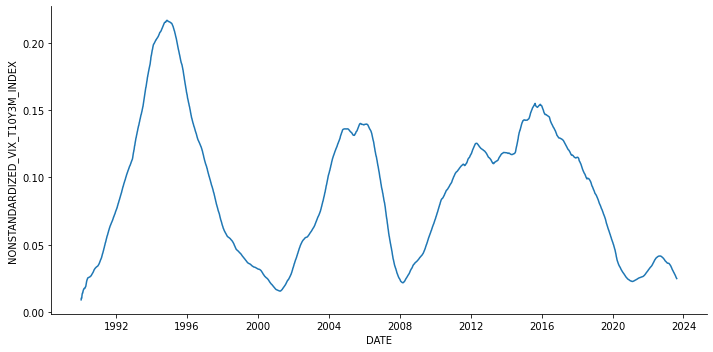

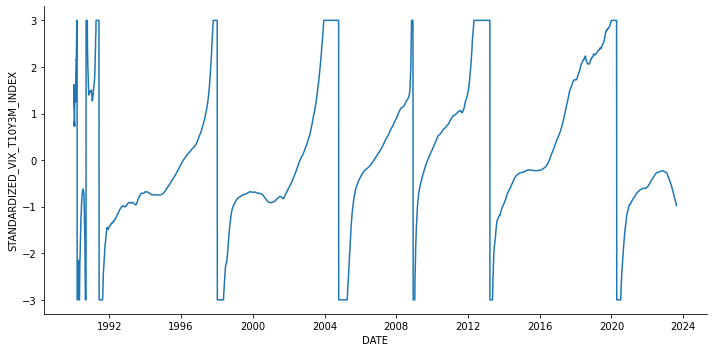

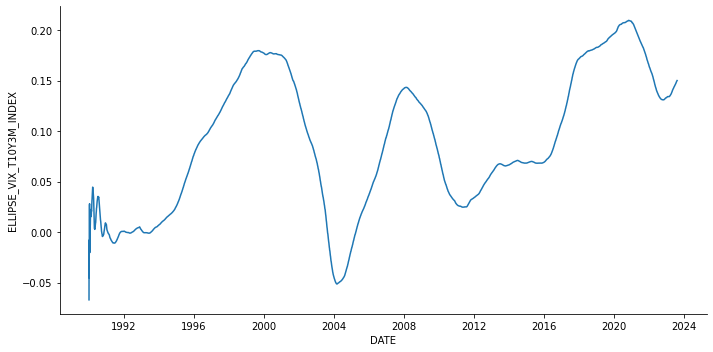

In [12]:
g1_index = sns.relplot(data=vixYieldCurve, x='DATE', y='NONSTANDARDIZED_VIX_T10Y3M_INDEX', kind="line", aspect=2)
g2_index = sns.relplot(data=vixYieldCurve, x='DATE', y='STANDARDIZED_VIX_T10Y3M_INDEX', kind="line", aspect=2)
g3_index = sns.relplot(data=vixYieldCurve, x='DATE', y='ELLIPSE_VIX_T10Y3M_INDEX', kind="line", aspect=2)

## Models

### Data
Then, I produce the probit models proposed in Lundgren's paper. We use the same recession indicator data - [NBER based Recession Indicators](https://fred.stlouisfed.org/series/USRECD) - as in the paper for the target variable to predict. The value of the recession indicator is 1 when the economy is in a recession and 0 when it is not. 

Next, I lag the recession indicator by 6, 12, and 18-month to use as the target variables for the probit models.


### Create Models
For each indicator (non-standardized, standardized, elliptical), I fit the model for predicting the recession indicator with 6, 12, 18-month lags and obtain a total of 9 probit models. 

In [ ]:
from statsmodels.discrete.discrete_model import Probit

usrec = pd.read_csv('./USRECDM.csv')
usrec['DATE'] = pd.to_datetime(usrec['DATE'])
usrec.set_index('DATE', inplace=True)
usrec['USRECDM_L6'] = usrec['USRECDM'].shift(-182)
usrec['USRECDM_L12'] = usrec['USRECDM'].shift(-365)
usrec['USRECDM_L18'] = usrec['USRECDM'].shift(-547)

vixYieldCurve = vixYieldCurve.merge(usrec[['USRECDM_L6', 'USRECDM_L12', 'USRECDM_L18']], on='DATE')
pd.merge(vixYieldCurve, usrec, on="DATE")

vixYieldCurve.dropna(inplace=True)


nonstandardized_model_L6 = Probit(vixYieldCurve['USRECDM_L6'], vixYieldCurve['NONSTANDARDIZED_VIX_T10Y3M_INDEX'])
nonstandardized_probit_model_L6 = nonstandardized_model_L6.fit()
print(nonstandardized_probit_model_L6.summary())

nonstandardized_model_L12 = Probit(vixYieldCurve['USRECDM_L12'], vixYieldCurve['NONSTANDARDIZED_VIX_T10Y3M_INDEX'])
nonstandardized_probit_model_L12 = nonstandardized_model_L12.fit()
print(nonstandardized_probit_model_L12.summary())

nonstandardized_model_L18 = Probit(vixYieldCurve['USRECDM_L18'], vixYieldCurve['NONSTANDARDIZED_VIX_T10Y3M_INDEX'])
nonstandardized_probit_model_L18 = nonstandardized_model_L18.fit()
print(nonstandardized_probit_model_L18.summary())


standardized_model_L6 = Probit(vixYieldCurve['USRECDM_L6'], vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX'])
standardized_probit_model_L6 = standardized_model_L6.fit()
print(standardized_probit_model_L6.summary())

standardized_model_L12 = Probit(vixYieldCurve['USRECDM_L12'], vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX'])
standardized_probit_model_L12 = standardized_model_L12.fit()
print(standardized_probit_model_L12.summary())

standardized_model_L18 = Probit(vixYieldCurve['USRECDM_L18'], vixYieldCurve['STANDARDIZED_VIX_T10Y3M_INDEX'])
standardized_probit_model_L18 = standardized_model_L18.fit()
print(standardized_probit_model_L18.summary())



ellipse_model_L6 = Probit(vixYieldCurve['USRECDM_L6'], vixYieldCurve['ELLIPSE_VIX_T10Y3M_INDEX'])
ellipse_probit_model_L6 = ellipse_model_L6.fit()
print(ellipse_probit_model_L6.summary())

ellipse_model_L12 = Probit(vixYieldCurve['USRECDM_L12'], vixYieldCurve['ELLIPSE_VIX_T10Y3M_INDEX'])
ellipse_probit_model_L12 = ellipse_model_L12.fit()
print(ellipse_probit_model_L12.summary())

ellipse_model_L18 = Probit(vixYieldCurve['USRECDM_L18'], vixYieldCurve['ELLIPSE_VIX_T10Y3M_INDEX'])
ellipse_probit_model_L18 = ellipse_model_L18.fit()
print(ellipse_probit_model_L18.summary())


